In [104]:
#!pip install escher
#!pip install cobra
#!pip install adjustText
#!pip install lifelines

In [2]:
# To be able to use escher
#!pip uninstall markupsafe -y
#!install markupsafe==2.0.1
# It's necessary to restart the kernel after that

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np
# from escher import Builder
# from cobra.io import load_model
from IPython.display import Image
from adjustText import adjust_text
from lifelines import KaplanMeierFitter
import warnings
import geopandas as gpd

In [45]:
df_incidence_country = pd.read_table('data/incidence_country.tsv', sep="\t")

In [44]:
df_incidence_country.head()

Country Population  ASR/100,000
0  Denmark     39,996        334.9
1  Ireland     27,067        326.6
2  Belgium     74,162        322.8
3  Hungary     62,399        321.6
4   France    422,828        320.1

In [27]:
from matplotlib.colors import LinearSegmentedColormap

# Defining the colors (red, dark orange, dark green)
colors = [(1, 0, 0), (1, 140/255, 0), (0, 100/255, 0)]
n_bins = 100  # Using 100 bins in the colormap

# Creating the colormap
custom_red_green = LinearSegmentedColormap.from_list('custom_red_green', colors, N=n_bins)

In [28]:
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

The sources of the raw data are :
* [www.cbioportal.org](http://www.cbioportal.org)
* [gco.iarc.fr/causes/](http://gco.iarc.fr/causes/)
* [https://doi.org/10.1038/s41598-021-04564-2](https://doi.org/10.1038/s41598-021-04564-2)

# I - Plot a risk matrix to reveal the most important cancers


In [29]:
# Specifying the column wished to be imported
col_to_keep = ["ICD", "Cancer", "Number", "Uncertainty interval", "Crude Rate", "ASR (World)", "Cum. risk", "empty"]

# Importing the raw data on incidence and mortality
dfIncidence = pd.read_csv('data/incidence.csv', index_col=None, skiprows=1, header=None, names=col_to_keep)

dfMortality = pd.read_csv('data/mortality.csv', index_col=None, skiprows=1, header=None, names=col_to_keep)

# Cleaning, this is necessary because the csv from the website ended with a separator
del dfIncidence["empty"]
del dfMortality["empty"]

# Merging the two data frames
dfJoined= pd.merge(dfIncidence,dfMortality,  on=['ICD','Cancer'])

# Removing row where 'column_name' is equal to 'value_to_remove', because this row show a sum of all cancer types
dfJoined = dfJoined[dfJoined['Cancer'] != 'Allcancersexcl.non-melanomaskincancer']

# Constructing the risk matrix
xPosition = dfJoined['Number_x'] / 37000000
yPosition = dfJoined['Number_y'] / dfJoined['Number_x']

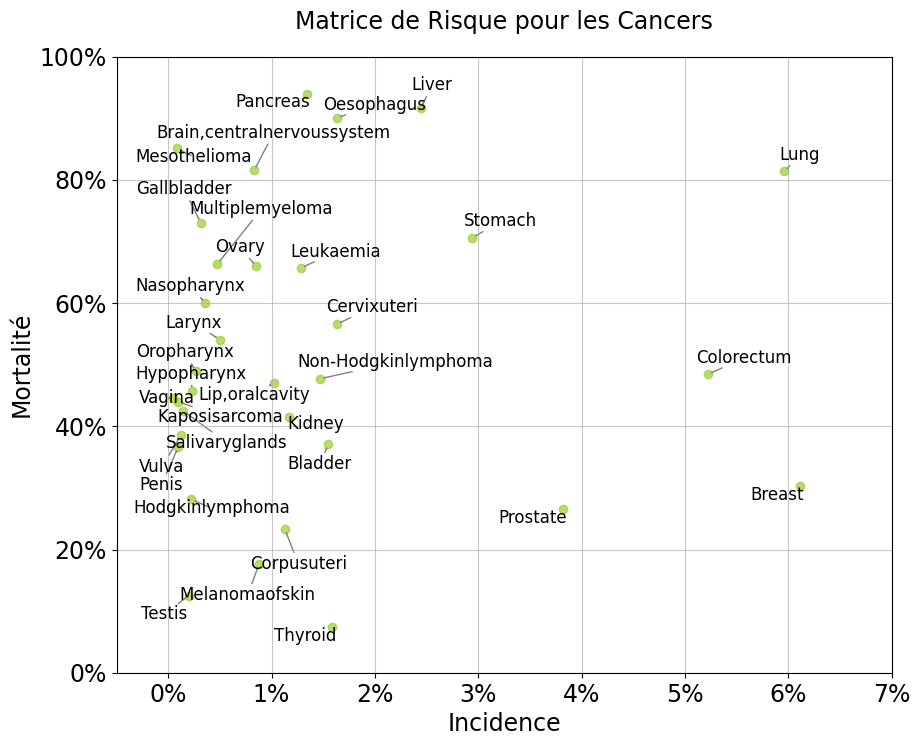

In [30]:
# Creating the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Creating scatterplot
ax.scatter(xPosition, yPosition, color='yellowgreen', alpha=0.7)

# Storing the text for each point to adjust them later
texts = []
for i in range(len(dfJoined)):
    texts.append(ax.text(xPosition.iloc[i], yPosition.iloc[i], dfJoined['Cancer'].iloc[i],
                         ha='center', va='bottom', fontsize=12)) # Added a bounding box for visibility

# Using adjustText to automatically adjust label positions
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'), ax=ax)  # Added arrows for clarity

# Adding titles and labels
ax.set_title('Matrice de Risque pour les Cancers', fontsize=17, pad=20)
ax.set_xlabel('Incidence', fontsize=17)
ax.set_ylabel('Mortalité', fontsize=17)
ax.set_xlim(-0.005, 0.07)
ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

# Formating y-axis as percentages
formatter = mticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))
ax.yaxis.set_major_formatter(formatter)
formatter = mticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x))
ax.xaxis.set_major_formatter(formatter)

# Adding grid for easier reading
ax.grid(True, alpha=0.7)

# Saving and showing the plot
plt.savefig('image/riskmatrix.png', transparent=True)
plt.show()

# II - Selecting 3 important cancers to see their causes.
## They should be in the top right corner of the risk matrix.  (Current selecion: Liver, Lung, Stomach)

## Uploading data for all cancers

In [31]:
dfCauses = pd.read_csv('data/article_on_causes_-_extraction.txt', sep="\t", index_col=None)

# Cleaning the titles
dfCauses.columns = [col.split('\n')[0].strip() for col in dfCauses.columns]
dfCauses.columns = [col.split('(')[0].strip() for col in dfCauses.columns]

# Translate to french
translation_dict = {
    'Tobacco': 'Tabac',
    'Overweight and obesity': 'Obésité',
    'Infections': 'Infections',
    'Radiation - UV': 'Radiation UV',
    'Alcohol': 'Alcool',
    'Occupation': 'Profession',
    'Radiation - ionising': 'Radiation ion.',
    'Air pollution': 'Pollution',
    'Processed meat': 'Viande industrielle',
    'Insufficient physical activity': 'Sédentarisme',
    'Post-menopausal hormones': 'Hormones',
    'Oral contraceptives': 'Contraceptifs'
}

# Replacing the values
dfCauses['Unnamed: 0'] = dfCauses['Unnamed: 0'].replace(translation_dict)

dfCauses.head()

Unnamed: 0  Oral cavity  Nasopharynx  Pharynx  Oesophagus  Stomach  \
0         Tabac         19.0         26.5     39.1        40.2     16.4   
1       Obésité          0.0          0.0      0.0        23.3      6.9   
2    Infections          8.5         80.0     53.2         0.0     25.6   
3  Radiation UV          0.0          0.0      0.0         0.0      0.0   
4        Alcool         30.3          0.0     33.0        13.7      0.0   

   Colon  Rectum  Anus  Liver  ...  Bladder  Kidney  Eye  Thyroid  Myeloma  \
0    6.6    12.7   0.0   21.4  ...     48.1    13.4  0.0      0.0      0.0   
1    7.4     8.2   0.0   15.7  ...      0.0    16.1  0.0      6.3      7.3   
2    0.0     0.0  91.5   11.0  ...      0.0     0.0  0.0      0.0      0.0   
3    0.0     0.0   0.0    0.0  ...      0.0     0.0  0.0      0.0      0.0   
4    6.2     6.7   0.0    5.9  ...      0.0     0.0  0.0      0.0      0.0   

   Hodgkin lymphoma  Non-Hodgkin lymphoma  Leukaemia  \
0               0.0                   0.0        3.7   
1               0.0                   0.0        0.0   
2              40.3                   4.3        0.0   
3               0.0                   0.0        0.0   
4               0.0                   0.0        0.0   

   Brain and other central nervous system  All cancers excl NMSC  
0                                     0.0                   14.6  
1                                     1.8                    3.3  
2                                     0.0                    2.9  
3                                     0.0                    5.8  
4                                     0.0                    2.6  

[5 rows x 35 columns]

## Bar plotting the causes

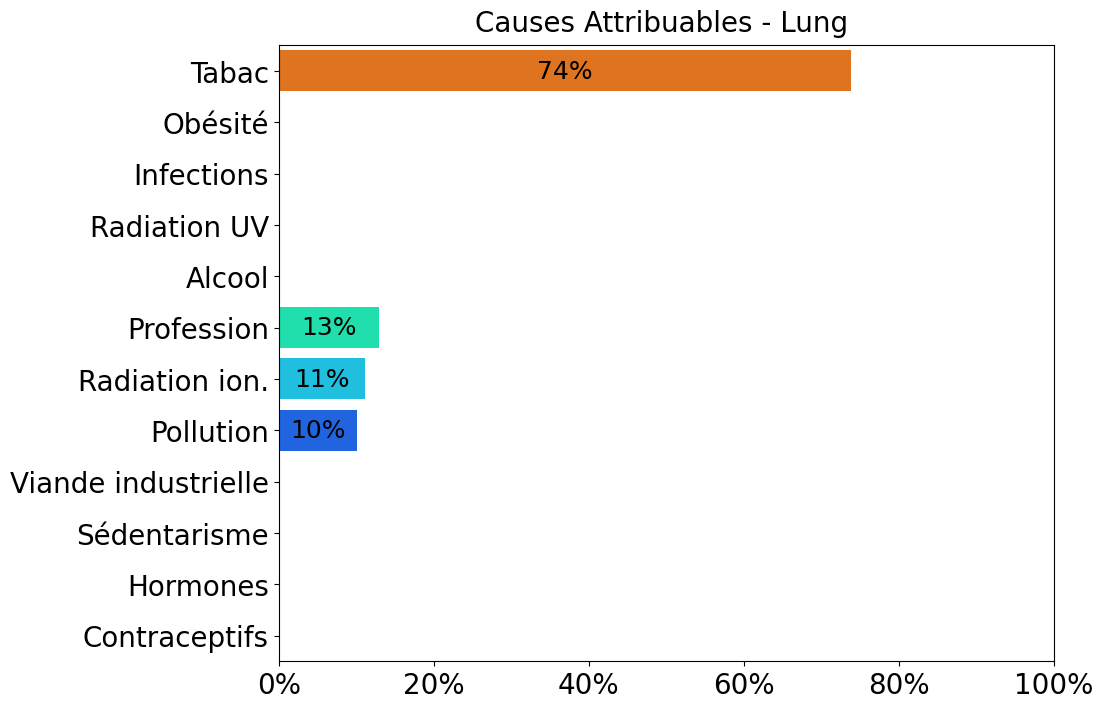

In [32]:
# Can be changed for 'Lung', 'Stomach' or 'Liver'
choice = 'Lung'

# Sizes for each slice
sizes = dfCauses[choice]
# Labels for each slice
labels = dfCauses['Unnamed: 0']

# Choosing a distinct color palette for each bar
colors = sns.color_palette("hsv", len(labels))

# Creating the barplot
fig, ax = plt.subplots(figsize=(10, 8))
barplot = sns.barplot(x=sizes, y=labels, palette=colors, ax=ax)

ax.set_title(f'Causes Attribuables - {choice} ', fontsize=20, pad=10)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(0, 100)  # Set x-axis scale from 0 to 100
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Formatting the x-axis as %
formatter = mticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x/100))
ax.xaxis.set_major_formatter(formatter)

# Adding the text on each bar
for p in barplot.patches:
    width = p.get_width()    # get bar length
    if width >= 2:  # Only add text for bars with a width greather than 2
        if width < 5:  # For bars less than 5%, place text after the bar
            ax.text(width + 1, p.get_y() + p.get_height() / 2, '{:1.0f}%'.format(width), 
                    ha='left', va='center', fontsize=18)
        else:  # For others, place text in the middle of the bar
            ax.text(width/2, p.get_y() + p.get_height() / 2, '{:1.0f}%'.format(width), 
                    ha='center', va='center', fontsize=18)

plt.savefig(f'image/causes-{choice}.png', transparent=True, bbox_inches='tight')
plt.show()

## For viruses, it's necessary to detail the infection bar because it may not the same between cancers

In [33]:
def parse_file_to_dataframe(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    virus_name = None
    parsed_data = []

    for line in lines:
        line_normalized = line.replace('\u2008', '')
        stripped_line = line_normalized.strip()

        if '\t' not in stripped_line:
            virus_name = stripped_line
        else:
            data = stripped_line.split('\t')
            parsed_data.append([virus_name] + data)

    # Create a pandas DataFrame
    column_names = ['Virus', 'Disease', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6']
    df = pd.DataFrame(parsed_data, columns=column_names)

    return df


dfInfection = parse_file_to_dataframe('c_infection.txt')

# Standardizing cancer name in the first column
dfInfection['Disease'] = dfInfection.apply(lambda rowAsSeries: rowAsSeries[1].replace('*',''),axis=1)
dfInfection['Disease'] = dfInfection['Disease'].map({'Non-Hodgkin lymphoma of gastric location':'not present','Cholangiocarcinoma':'not present','Cardia gastric cancer':'not present','Burkitt lymphoma':'not present','Anus squamous cell carcinoma':'not present','Non-cardia gastric cancer':'Stomach','Vulva carcinoma':'Vulva','Vagina carcinoma':'Vagina','Penis carcinoma':'Penis','Oropharyngeal carcinoma':'Oropharynx','Other non-Hodgkin lymphoma':'Non-Hodgkinlymphoma','Nasopharynx carcinoma':'Nasopharynx','Hepatocellular carcinoma':'Liver','Oral cavity cancer':'Lip,oralcavity','Adult T-cell leukaemia and lymphoma':'Leukaemia','Larynx cancer':'Larynx','Kaposi sarcoma':'Kaposisarcoma','Hodgkin lymphoma':'Hodgkinlymphoma','Cervix uteri carcinoma':'Cervixuteri','Bladder carcinoma':'Bladder'})


# Converting 'Data6' and 'Data5' to numeric (integers or floats)
dfInfection['Data6'] = pd.to_numeric(dfInfection['Data6'], errors='coerce')
dfInfection['Data5'] = pd.to_numeric(dfInfection['Data5'], errors='coerce')

# Replacing NaNs with zeros if necessary
dfInfection['Data6'].fillna(0, inplace=True)
dfInfection['Data5'].fillna(0, inplace=True)

# finding proportions
dfInfection['proportion'] = dfInfection['Data6']/dfInfection['Data5']

dfInfection.head()

Virus      Disease   Data1   Data2   Data3   Data4   Data5  \
0   Helicobacter pylori      Stomach  550000  490000  300000  270000  850000   
1   Helicobacter pylori  not present  130000   27000   46000    8900  180000   
2   Helicobacter pylori  not present   12000    8700   10000    7600   22000   
3  Human papillomavirus  Cervixuteri      ..      ..  570000  570000  570000   
4  Human papillomavirus   Oropharynx  110000   34000   26000    8100  140000   

    Data6  proportion  
0  760000    0.894118  
1   36000    0.200000  
2   16000    0.727273  
3  570000    1.000000  
4   42000    0.300000

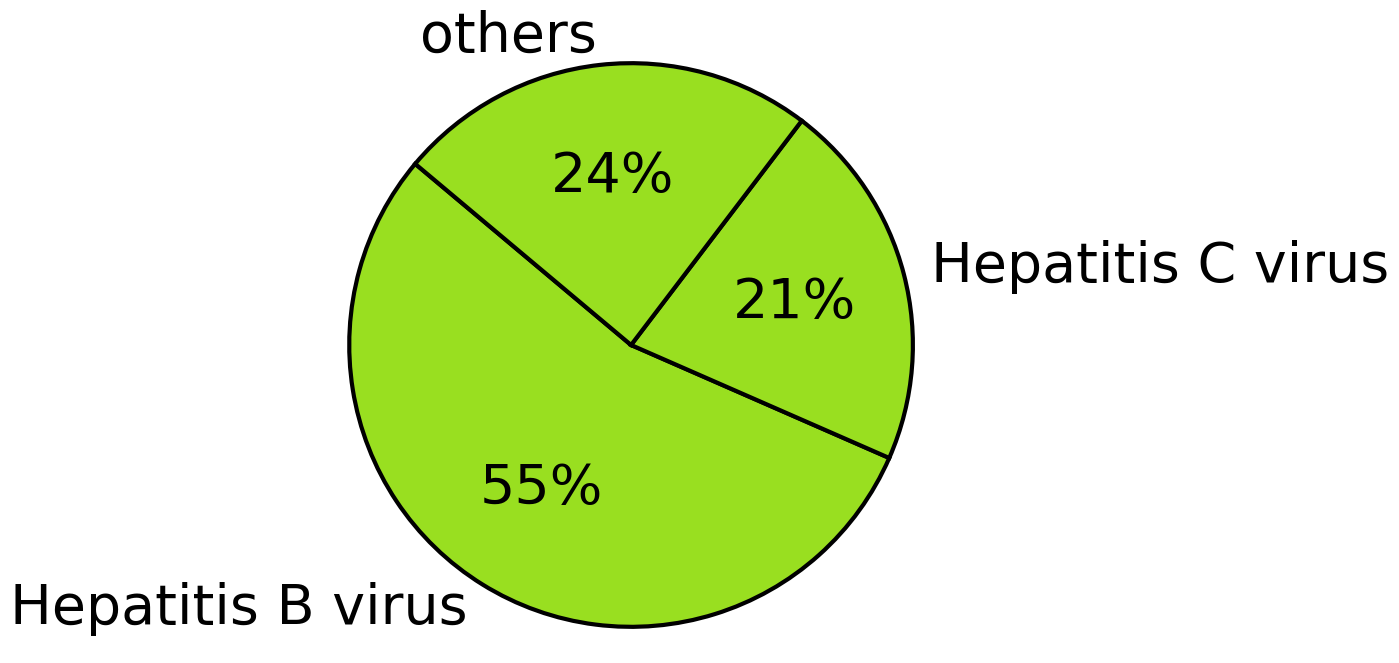

In [34]:
# Can be changed for 'Lung', 'Stomach' or 'Liver'
chosenCancer = 'Liver'

# function that generates only green shades
def generate_green_shades(n):
    """ Generate n different shades of green """
    base_color = np.array([153, 223, 32])  # A base green color
    return [(base_color * (1 - i / n) / 255).tolist() for i in range(n)]

# Sizes for each slice
series_sizes = dfInfection['proportion'][dfInfection['Disease'] == chosenCancer]*100 #exemple [54.5455,21.2121]
fractionOfKnownCauses = series_sizes.sum()
sizes = series_sizes.to_list()
sizes.append(100-fractionOfKnownCauses) #creating a last pizz slice to show unknown causes

# Labels for each slice
series_labels = dfInfection['Virus'][dfInfection['Disease'] == chosenCancer]#example ['Hepatitis B virus', 'Hepatitis C virus']
labels = series_labels.to_list()
labels.append('others')

# Plotting
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.f%%', startangle=140, colors=[(153/255, 223/255, 32/255)]*len(sizes), wedgeprops={'linewidth': 3, 'edgecolor': 'black'},textprops={'fontsize': 40})
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

plt.savefig(f'image/pie-{chosenCancer}.png', transparent=True, bbox_inches='tight')
plt.show()

# III - Now we proceed to compare the eficacy of the treatments for the same 3 types

## Generating higher resolution from Stomach database

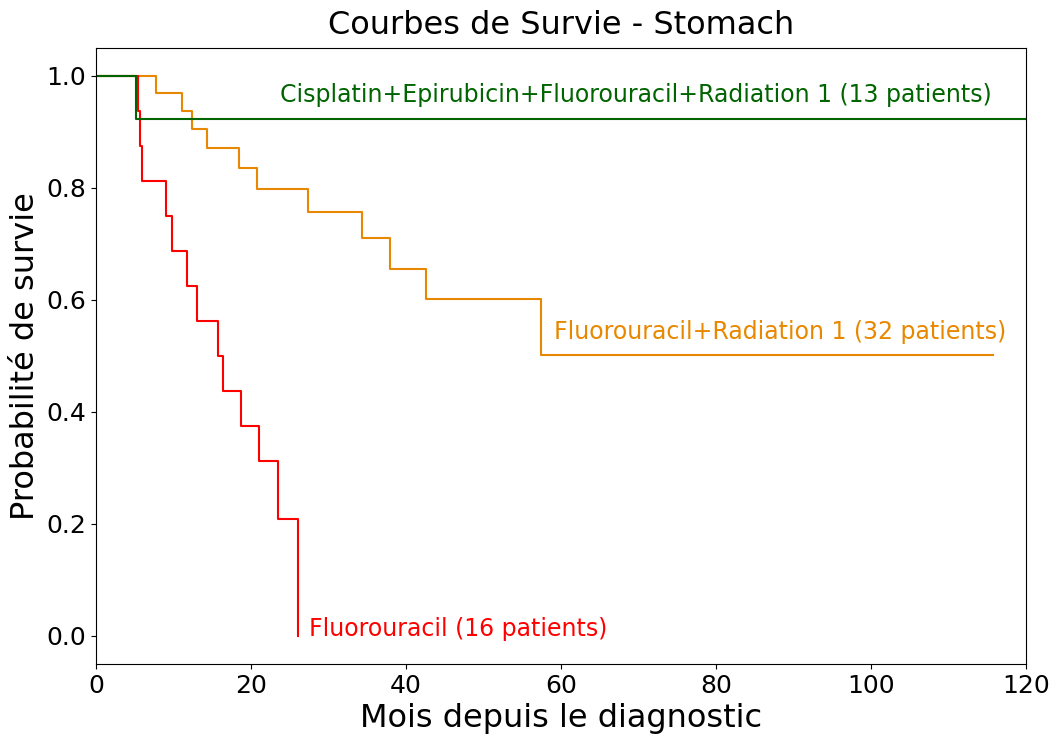

In [37]:
# Importing the raw data of survival, treatments and types
dfSurvival = pd.read_csv(  'data/stomach/data_clinical_patient.txt', sep="\t",index_col=None, skiprows=4)
dfTreatments = pd.read_csv('data/stomach/data_timeline_treatment.txt', sep="\t", index_col=None)
dfTypes = pd.read_csv(     'data/stomach/stad_tcga_pan_can_atlas_2018_clinical_data.tsv', sep="\t", index_col=None) 
dfTypes_relevant = dfTypes[['Patient ID','Cancer Type','Cancer Type Detailed']]
dfTypes_relevant = dfTypes_relevant.rename(columns={'Patient ID': 'PATIENT_ID'})

# Obtain a table with one patient per line, because on the treatment table each line is a treatment of a patient
# To do so, treatments will be grouped into the same string, separated by a "+" sign
dfTreatments_sorted = dfTreatments.sort_values(by=['PATIENT_ID', 'AGENT']) # Sorting the DataFrame by patient_id and treatment in alphabetical order
dfTreatments_unique = dfTreatments_sorted.drop_duplicates(subset=['PATIENT_ID', 'AGENT']) # Removing duplicates
dfTreatments_unique.dropna(subset=['AGENT'], inplace=True)
dfTreatmentsGrouped = dfTreatments_unique.groupby('PATIENT_ID')['AGENT'].agg('+'.join).reset_index()

# Merging the 3 data frames
dfSurvivalAndTreatmentAll = pd.merge(dfSurvival,dfTreatmentsGrouped,  on='PATIENT_ID')
dfSurvivalAndTreatmentAll = pd.merge(dfSurvivalAndTreatmentAll,dfTypes_relevant,  on='PATIENT_ID')

# Adapting the status column from a string to a binary value
dfSurvivalAndTreatmentAll['OS_STATUS'] = dfSurvivalAndTreatmentAll['OS_STATUS'].replace({'1:DECEASED': 1, '0:LIVING': 0})
dfSurvivalAndTreatmentAll.dropna(subset=['OS_MONTHS'], inplace=True)

dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll

# Creating a Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Plotting survival curves for 3 most common treatments
plt.figure(figsize=(12, 8))

commonTreatments = dfSurvivalAndTreatmentAll['AGENT'].value_counts().head(3).index.tolist()

# Initializing a list to store the last points
last_points = []

for treatment_type in commonTreatments:
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'])
    
    # Storing the last point of the curve
    last_points.append(kmf.survival_function_.values[-1][0])

# Creating a color map from red to green
norm = plt.Normalize(min(last_points), max(last_points))
colors = custom_red_green(norm(last_points))

# Ploting each curve
for i, treatment_type in enumerate(commonTreatments):
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    patientsFound = len(treatment_data)
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'], label=treatment_type + ' (' + str(patientsFound) + ' patients)')
    
    # Plot the survival curve with the specified color
    ax = kmf.plot_survival_function(ci_show=False, color=colors[i])
    
    # Annotating the curve with its label
    x = kmf.survival_function_.index[-1]  # x-coordinate
    if x>120:
        x= x -100 # Reposition x to go back
        y = kmf.survival_function_.values[-1][0]+0.03  # y-coordinate
    elif x>50:
        x= x -58 # Reposition x to go back
        y = kmf.survival_function_.values[-1][0]+0.03  # y-coordinate
    else:
        y = kmf.survival_function_.values[-1][0]
 
    plt.annotate(treatment_type + ' (' + str(patientsFound) + ' patients)',
                 xy=(x, y), xycoords='data',
                 xytext=(8, 0), textcoords='offset points',
                 fontsize=17, color=colors[i])

plt.xlim(0, 120)    

# Seting text sizes for different elements
plt.title('Courbes de Survie - Stomach', fontsize=23, pad=10)
plt.xlabel('Mois depuis le diagnostic', fontsize=23)
plt.ylabel('Probabilité de survie', fontsize=23)

# Adjusting the tick label size for both x and y axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax = plt.gca()
ax.legend_ = None

plt.savefig('image/survival_plot_stomach.png', transparent=True, bbox_inches='tight')
plt.show()

## Generate higher resolution from Liver database

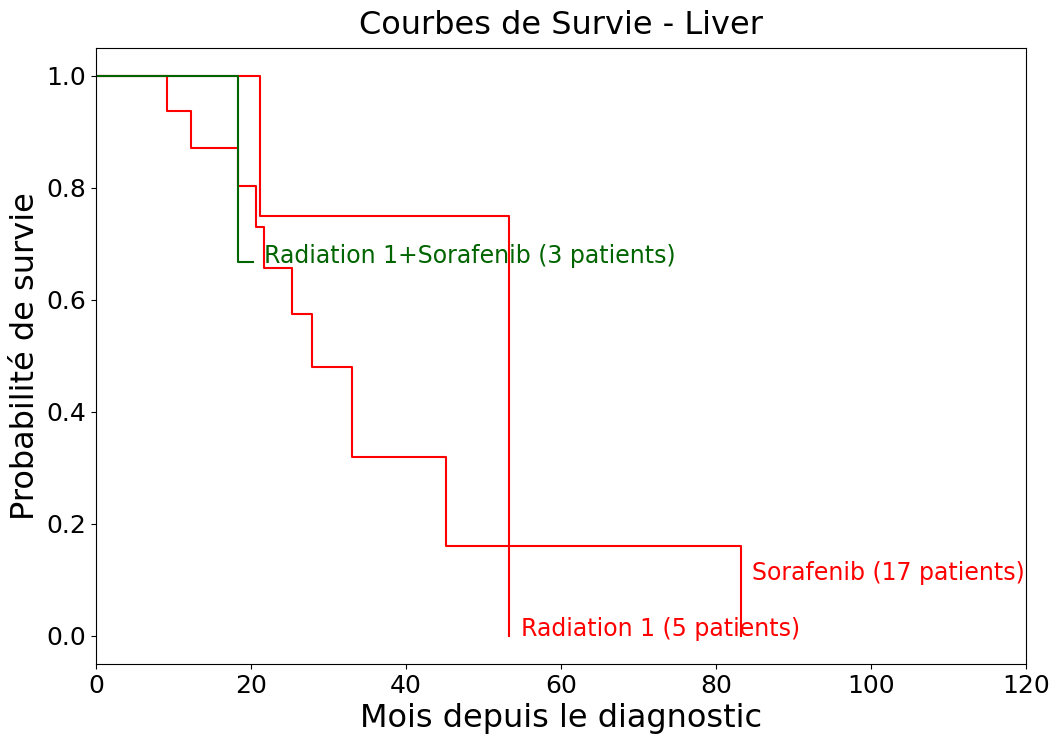

In [39]:
# Importing the raw data of survival, treatments and types
dfSurvival = pd.read_csv(  'data/liver/data_clinical_patient.txt', sep="\t",index_col=None, skiprows=4)
dfTreatments = pd.read_csv('data/liver/data_timeline_treatment.txt', sep="\t", index_col=None)
dfTypes = pd.read_csv(     'data/liver/lihc_tcga_pan_can_atlas_2018_clinical_data.tsv', sep="\t", index_col=None) 
dfTypes_relevant = dfTypes[['Patient ID','Cancer Type','Cancer Type Detailed']]
dfTypes_relevant = dfTypes_relevant.rename(columns={'Patient ID': 'PATIENT_ID'})

dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll

# Obtain a table with one patient per line, because on the treatment table each line is a treatment of a patient
# To do so, treatments will be grouped into the same string, separated by a "+" sign
dfTreatments_sorted = dfTreatments.sort_values(by=['PATIENT_ID', 'AGENT']) # Sorting the DataFrame by patient_id and treatment in alphabetical order
dfTreatments_unique = dfTreatments_sorted.drop_duplicates(subset=['PATIENT_ID', 'AGENT']) # Removing duplicates
dfTreatments_unique.dropna(subset=['AGENT'], inplace=True)
dfTreatmentsGrouped = dfTreatments_unique.groupby('PATIENT_ID')['AGENT'].agg('+'.join).reset_index()

# Merging the 3 data frames
dfSurvivalAndTreatmentAll = pd.merge(dfSurvival,dfTreatmentsGrouped,  on='PATIENT_ID')
dfSurvivalAndTreatmentAll = pd.merge(dfSurvivalAndTreatmentAll,dfTypes_relevant,  on='PATIENT_ID')

# Adapting the status column from a string to a binary value
dfSurvivalAndTreatmentAll['OS_STATUS'] = dfSurvivalAndTreatmentAll['OS_STATUS'].replace({'1:DECEASED': 1, '0:LIVING': 0})

# Creating a Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Plotting survival curves for 3 most common treatments
plt.figure(figsize=(12, 8))

commonTreatments = dfSurvivalAndTreatmentAll['AGENT'].value_counts().head(3).index.tolist()

# Initializing list to store the last points
last_points = []

for treatment_type in commonTreatments:
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'])
    
    # Storing the last point of the curve
    last_points.append(kmf.survival_function_.values[-1][0])

# Creating a color map from red to green
norm = plt.Normalize(min(last_points), max(last_points))
colors = custom_red_green(norm(last_points))

# Ploting each curve
for i, treatment_type in enumerate(commonTreatments):
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    patientsFound = len(treatment_data)
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'], label=treatment_type + ' (' + str(patientsFound) + ' patients)')
    
    # Ploting the survival curve with the specified color
    ax = kmf.plot_survival_function(ci_show=False, color=colors[i])
    
    # Annotating the curve with its label
    x = kmf.survival_function_.index[-1]  # x-coordinate
    if x > 70:
        y = kmf.survival_function_.values[-1][0]+0.1  # y-coordinate
    else:
        y = kmf.survival_function_.values[-1][0]
    plt.annotate(treatment_type + ' (' + str(patientsFound) + ' patients)',
                 xy=(x, y), xycoords='data',
                 xytext=(8, 0), textcoords='offset points',
                 fontsize=17, color=colors[i])

plt.xlim(0, 120)    

# Seting text sizes for different elements
plt.title('Courbes de Survie - Liver', fontsize=23, pad=10)
plt.xlabel('Mois depuis le diagnostic', fontsize=23)
plt.ylabel('Probabilité de survie', fontsize=23)

# Adjusting the tick label size for both x and y axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax = plt.gca()
ax.legend_ = None

plt.savefig('image/survival_plot_liver.png', transparent=True, bbox_inches='tight')
plt.show()

## generate higher resolution from Lung database

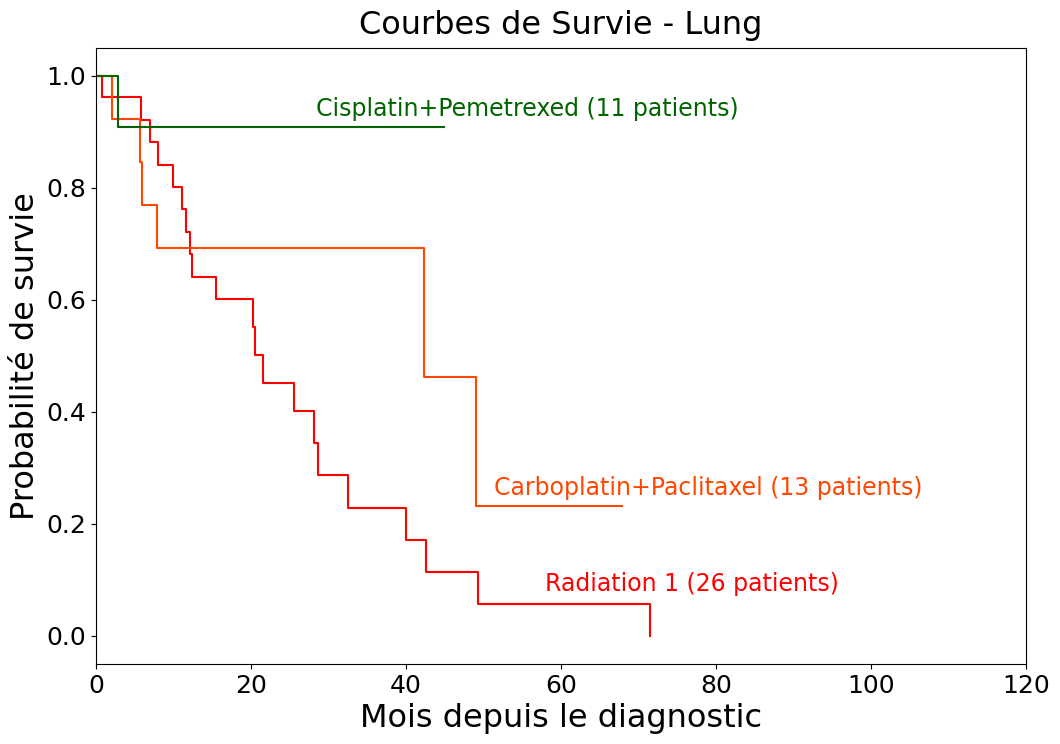

In [40]:
# Importing the raw data of survival, treatments and types
dfSurvival = pd.read_csv(  'data/lung/data_clinical_patient.txt', sep="\t",index_col=None, skiprows=4)
dfTreatments = pd.read_csv('data/lung/data_timeline_treatment.txt', sep="\t", index_col=None)
dfTypes = pd.read_csv(     'data/lung/luad_tcga_pan_can_atlas_2018_clinical_data.tsv', sep="\t", index_col=None) 
dfTypes_relevant = dfTypes[['Patient ID','Cancer Type','Cancer Type Detailed']]
dfTypes_relevant = dfTypes_relevant.rename(columns={'Patient ID': 'PATIENT_ID'})

# Obtain a table with one patient per line, because on the treatment table each line is a treatment of a patient
# To do so, treatments will be grouped into the same string, separated by a "+" sign
dfTreatments_sorted = dfTreatments.sort_values(by=['PATIENT_ID', 'AGENT']) # Sorting the DataFrame by patient_id and treatment in alphabetical order
dfTreatments_unique = dfTreatments_sorted.drop_duplicates(subset=['PATIENT_ID', 'AGENT']) # Removing duplicates
dfTreatments_unique.dropna(subset=['AGENT'], inplace=True)
dfTreatmentsGrouped = dfTreatments_unique.groupby('PATIENT_ID')['AGENT'].agg('+'.join).reset_index()

# Merging the 3 data frames
dfSurvivalAndTreatmentAll = pd.merge(dfSurvival,dfTreatmentsGrouped,  on='PATIENT_ID')
dfSurvivalAndTreatmentAll = pd.merge(dfSurvivalAndTreatmentAll,dfTypes_relevant,  on='PATIENT_ID')

# Adapting the status column from a string to a binary value
dfSurvivalAndTreatmentAll['OS_STATUS'] = dfSurvivalAndTreatmentAll['OS_STATUS'].replace({'1:DECEASED': 1, '0:LIVING': 0})

dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll

# Create a Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Plotting survival curves for 3 most common treatments
plt.figure(figsize=(12, 8))

commonTreatments = dfSurvivalAndTreatmentAll['AGENT'].value_counts().head(3).index.tolist()

# Initializing list to store the last points
last_points = []

for treatment_type in commonTreatments:
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'])
    
    # Storing the last point of the curve
    last_points.append(kmf.survival_function_.values[-1][0])

# Creating a color map from red to green
norm = plt.Normalize(min(last_points), max(last_points))
colors = custom_red_green(norm(last_points))

# Ploting each curve
for i, treatment_type in enumerate(commonTreatments):
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['AGENT'] == treatment_type]
    patientsFound = len(treatment_data)
    
    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'], label=treatment_type + ' (' + str(patientsFound) + ' patients)')
    
    # Ploting the survival curve with the specified color
    ax = kmf.plot_survival_function(ci_show=False, color=colors[i])
    
    # Annotating the curve with its label
    x = kmf.survival_function_.index[-1]
    if x >70:
        x = kmf.survival_function_.index[-1]-15  # x-coordinate
        y = kmf.survival_function_.values[-1][0]+0.08  # y-coordinate
    else:
        x = kmf.survival_function_.index[-1]-18  # x-coordinate
        y = kmf.survival_function_.values[-1][0]+0.02  # y-coordinate    
        
    plt.annotate(treatment_type + ' (' + str(patientsFound) + ' patients)',
                 xy=(x, y), xycoords='data',
                 xytext=(8, 0), textcoords='offset points',
                 fontsize=17, color=colors[i])

plt.xlim(0, 120)    

# Seting text sizes for different elements
plt.title('Courbes de Survie - Lung', fontsize=23, pad=10)
plt.xlabel('Mois depuis le diagnostic', fontsize=23)
plt.ylabel('Probabilité de survie', fontsize=23)

# Adjusting the tick label size for both x and y axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax = plt.gca()
ax.legend_ = None

plt.savefig('image/survival_plot_lung.png', transparent=True, bbox_inches='tight')
plt.show()

# IV - World map for incidence and mortality

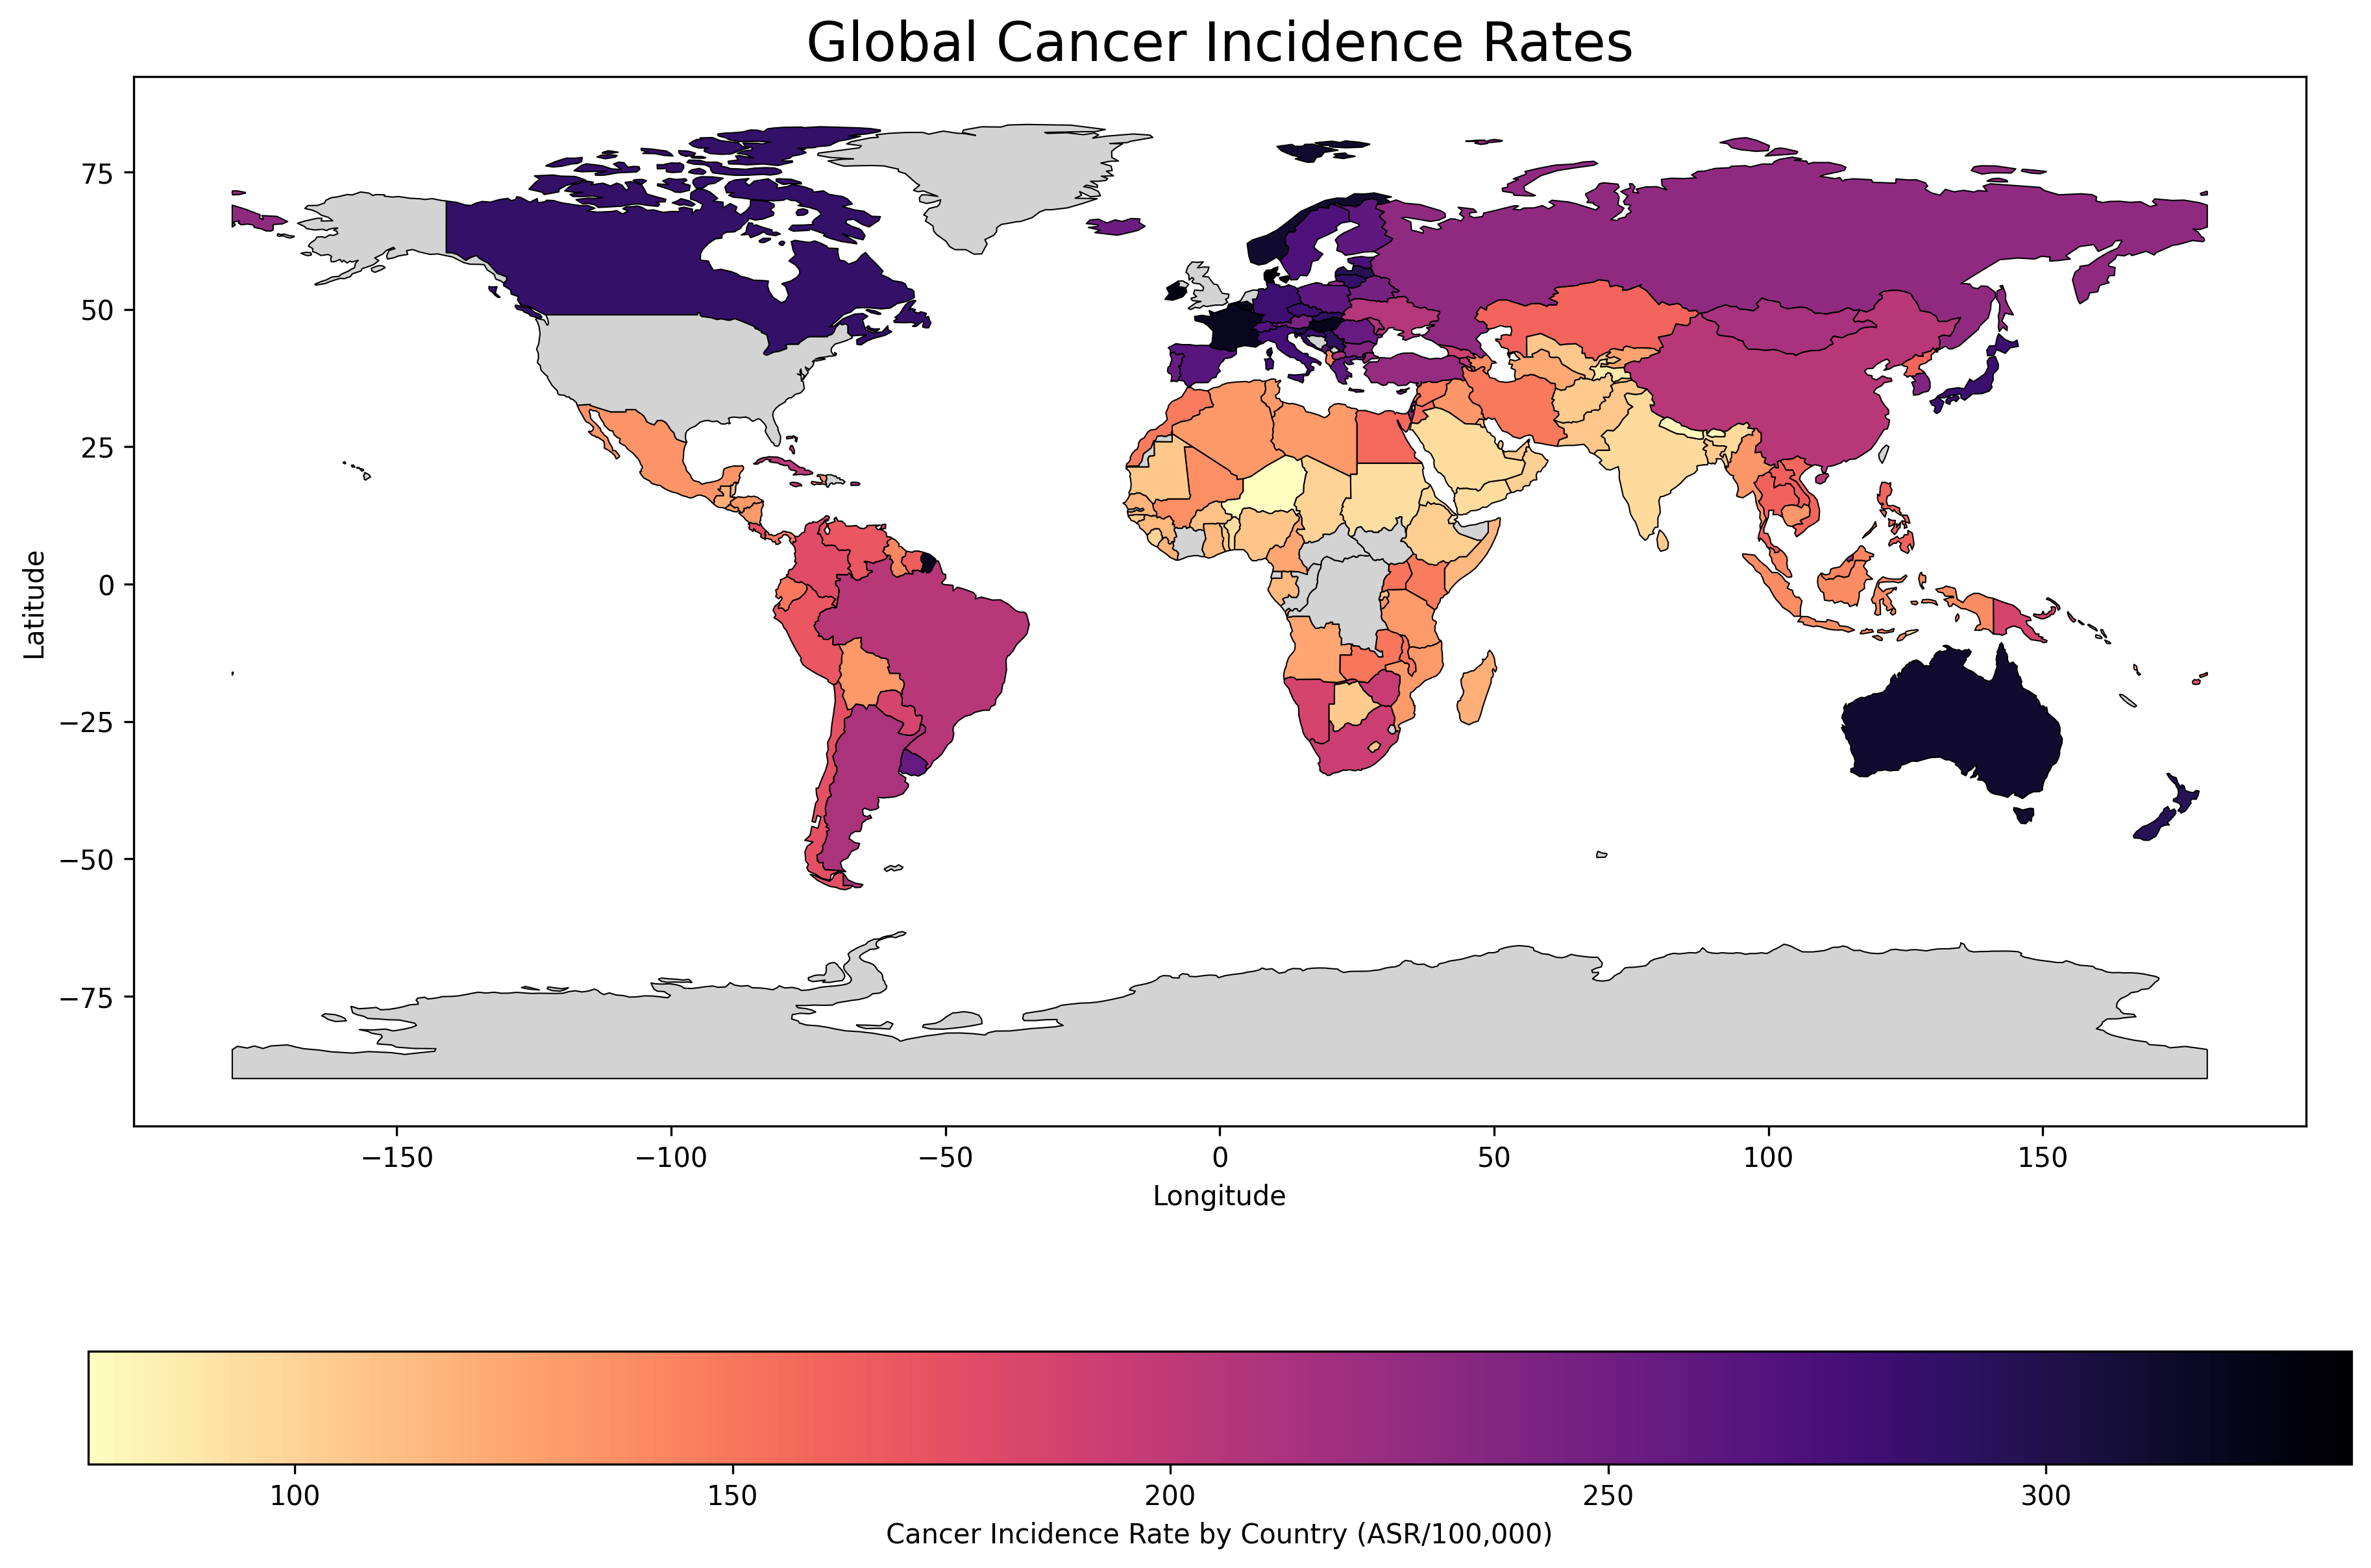

In [96]:
# Importing data
df_incidence_country = pd.read_table('data/incidence_country.tsv', sep="\t")

# Renaming columns for clarity
df_incidence_country.rename(columns={df_incidence_country.columns[0]: 'country',
                                     df_incidence_country.columns[2]: 'incidence_rate'}, inplace=True)

# Loading the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Adding the incidence data to the world map
world = world.merge(df_incidence_country, how="left", left_on="name", right_on="country")

# Creating the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=300)

# Ploting the world map with countries colored
world.plot(column='incidence_rate', ax=ax, legend=True,
           legend_kwds={'label': "Cancer Incidence Rate by Country (ASR/100,000)", 'orientation': "horizontal"},
           missing_kwds={'color': 'lightgrey'},  # Color for missing countries
           cmap='magma_r',
           edgecolor='black',
           linewidth=0.5)

# Adding labels for latitude and longitude
ax.tick_params(labelsize=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title('Global Cancer Incidence Rates', fontsize=20)

plt.savefig('image/incidence_worldwide.png', transparent=True, bbox_inches='tight')
plt.show()

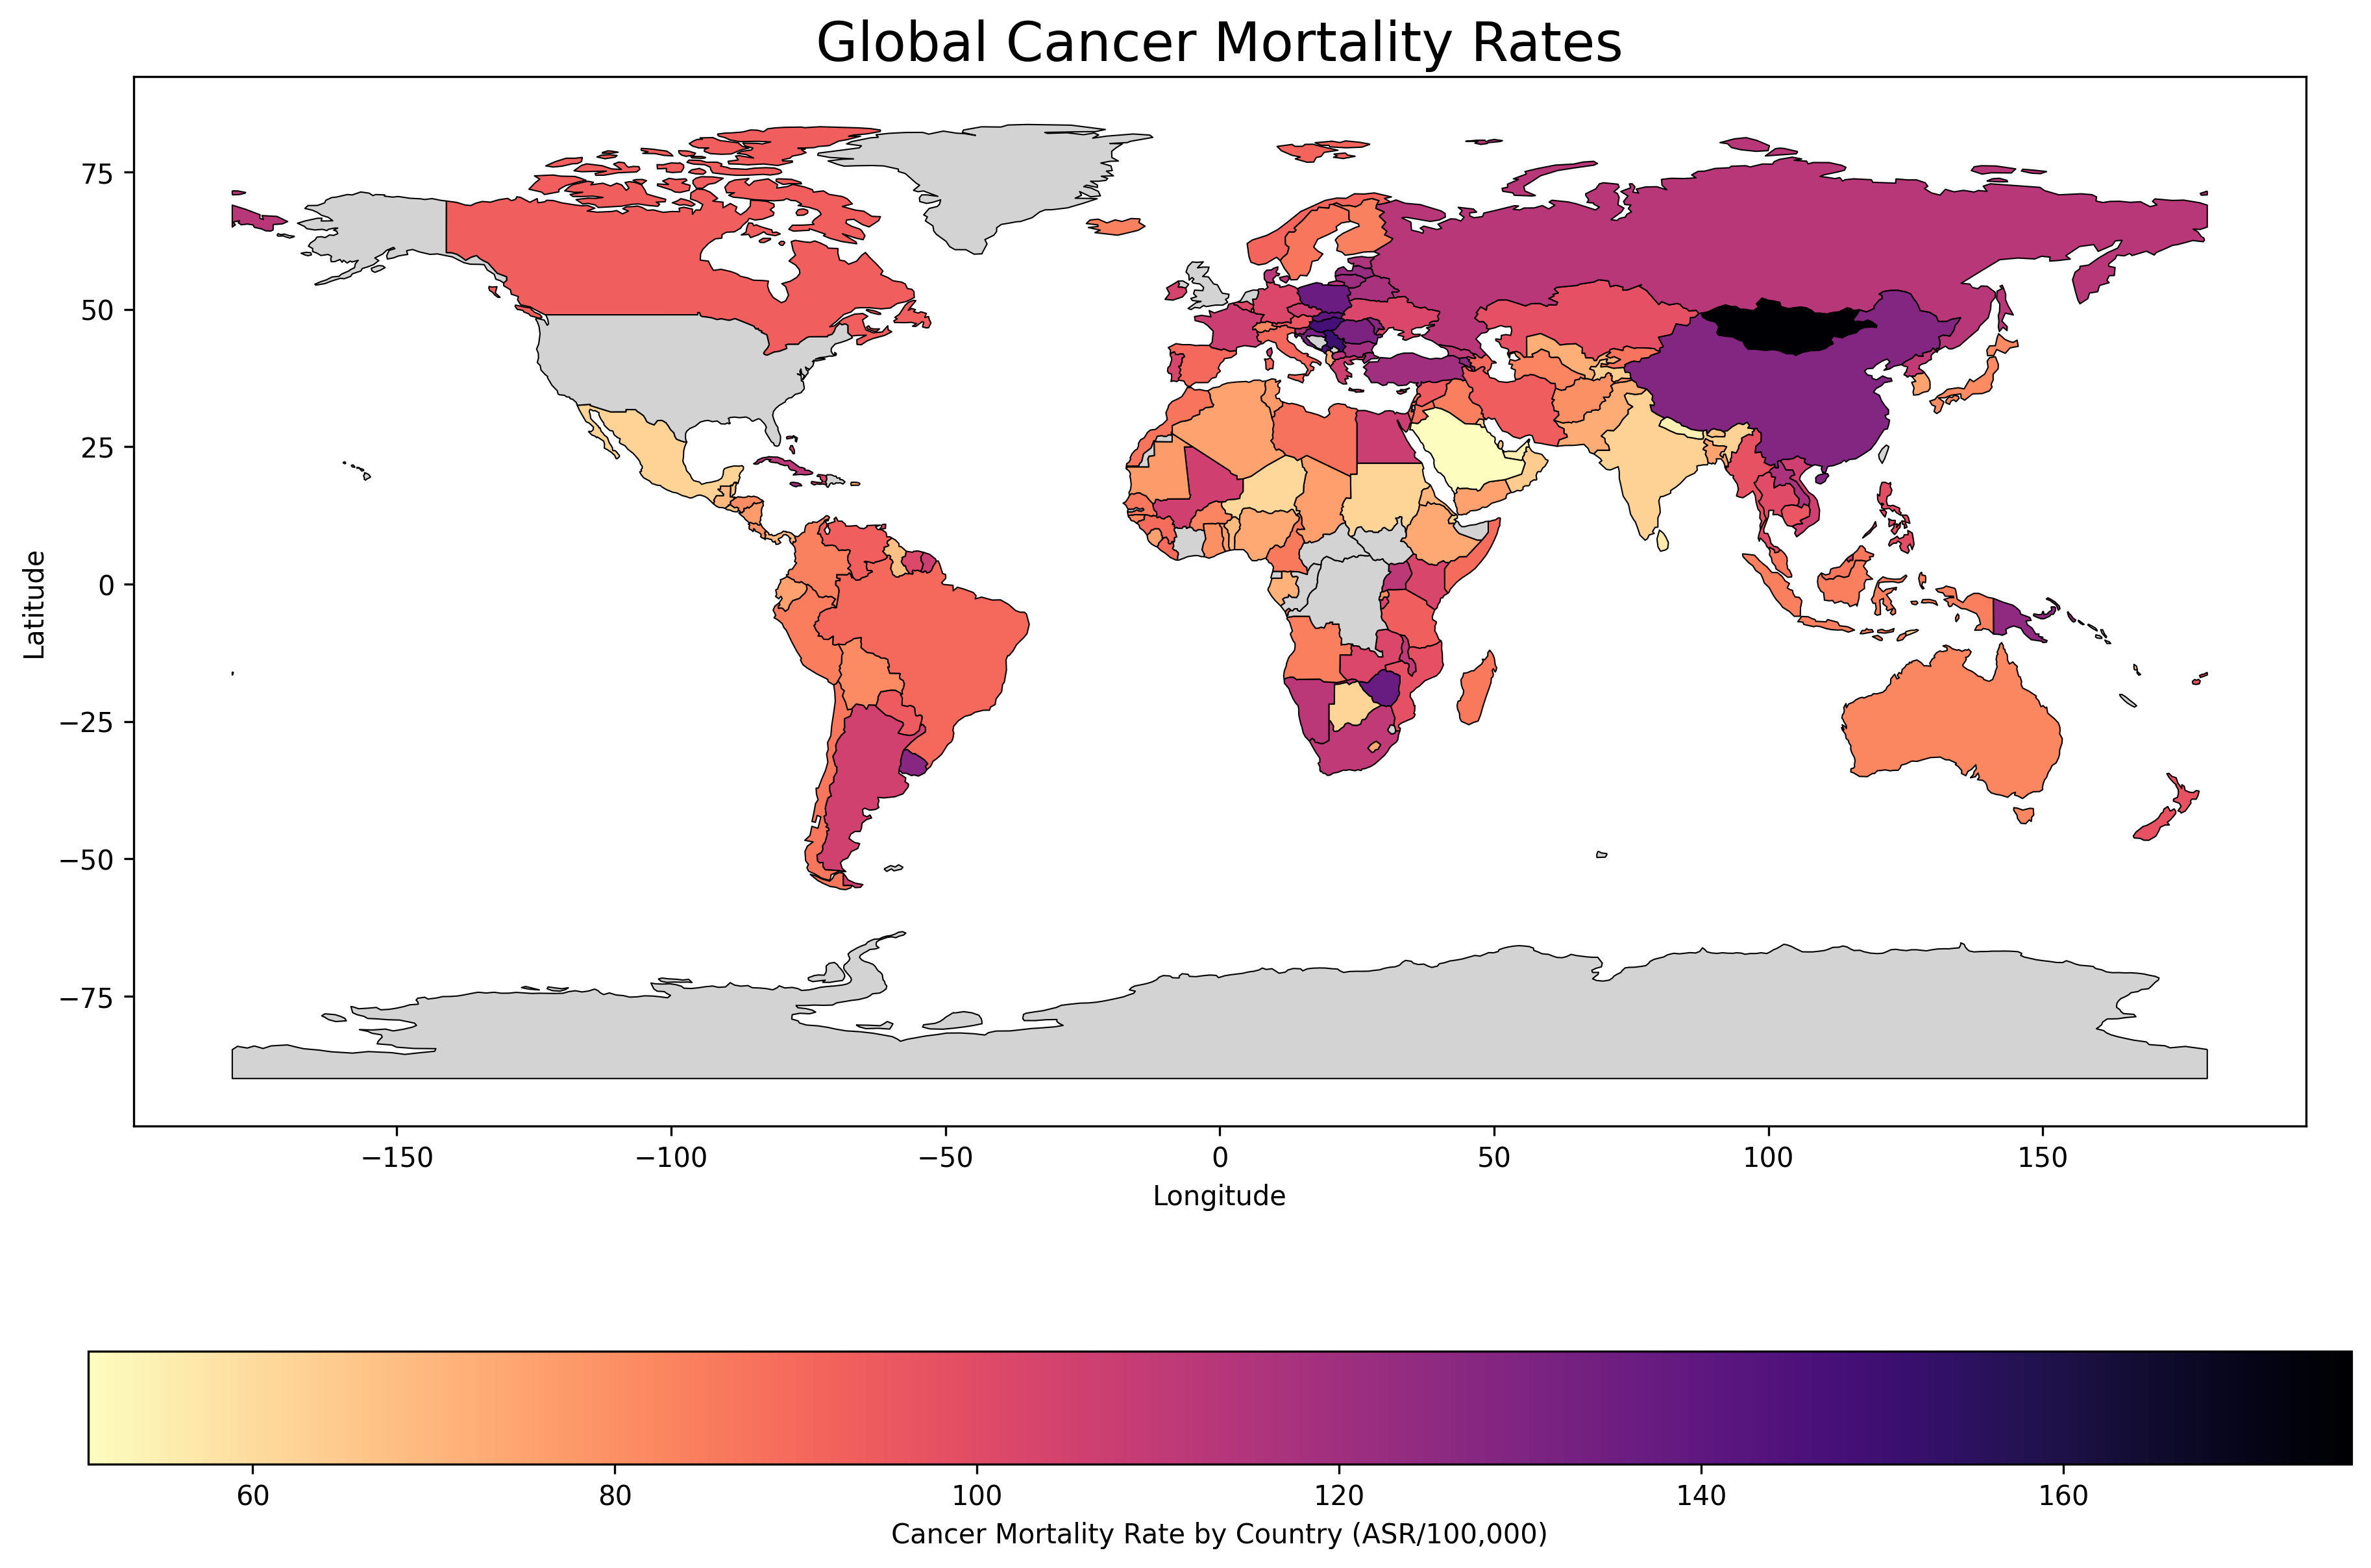

In [97]:
# Importing data
df_mortality_country = pd.read_table('data/mortality_country.tsv', sep="\t")

# Renaming columns for clarity
df_mortality_country.rename(columns={df_mortality_country.columns[0]: 'country',
                                     df_mortality_country.columns[2]: 'mortality_rate'}, inplace=True)

# Loading the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Adding the mortality data to the world map
world = world.merge(df_mortality_country, how="left", left_on="name", right_on="country")

# Creating the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=300)

# Ploting the world map with countries colored
world.plot(column='mortality_rate', ax=ax, legend=True,
           legend_kwds={'label': "Cancer Mortality Rate by Country (ASR/100,000)", 'orientation': "horizontal"},
           missing_kwds={'color': 'lightgrey'},  # Color for missing countries
           cmap='magma_r',
           edgecolor='black',
           linewidth=0.5)

# Adding labels for latitude and longitude
ax.tick_params(labelsize=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title('Global Cancer Mortality Rates', fontsize=20)

plt.savefig('image/mortality_worldwide.png', transparent=True, bbox_inches='tight')
plt.show()

## The end

## Codes examples that we tried, they might be useful on the future :

## Example of KM survival curve with fake data

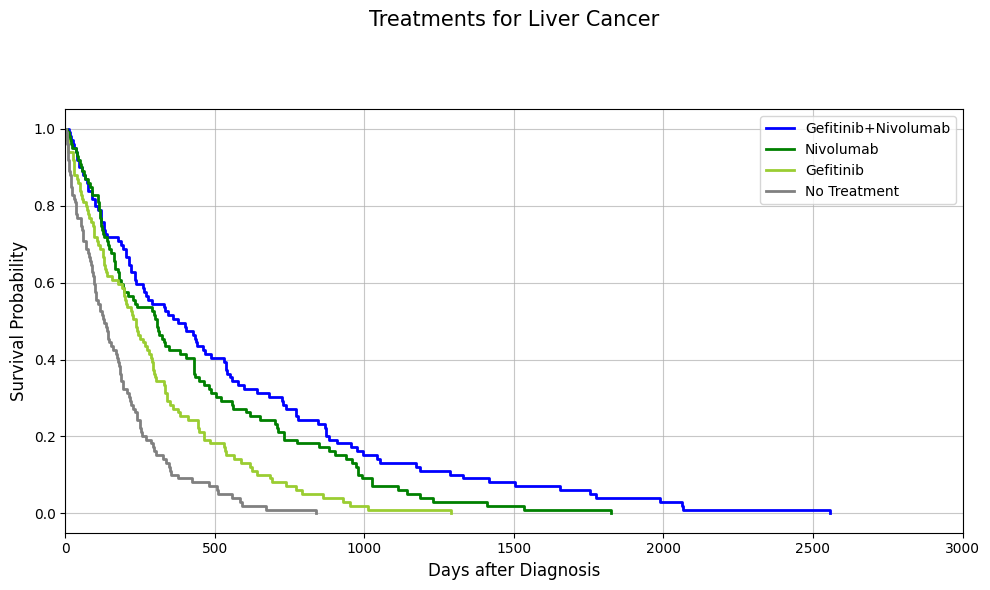

In [41]:
# Seting a random seed for reproducibility
np.random.seed(42)

# Number of individuals in each group
n = 100

# Generating random survival times
time_treatment1 = np.random.exponential(scale=590, size=n)
time_treatment2 = np.random.exponential(scale=430, size=n)
time_treatment3 = np.random.exponential(scale=280, size=n)
time_no_treatment = np.random.exponential(scale=180, size=n)

# Sorting the survival times
time_treatment1.sort()
time_treatment2.sort()
time_treatment3.sort()
time_no_treatment.sort()

# Generating survival probabilities
prob_treatment1 = np.linspace(1, 0, len(time_treatment1))
prob_treatment2 = np.linspace(1, 0, len(time_treatment2))
prob_treatment3 = np.linspace(1, 0, len(time_treatment3))
prob_no_treatment = np.linspace(1, 0, len(time_no_treatment))

# Plotting the survival curves
plt.figure(figsize=(10, 6))

# Ploting each curve
plt.step(time_treatment1, prob_treatment1, where="post", label="Gefitinib+Nivolumab", linewidth=2, linestyle='-', color='blue')
plt.step(time_treatment2, prob_treatment2, where="post", label="Nivolumab", linewidth=2, linestyle='-', color='green')
plt.step(time_treatment3, prob_treatment3, where="post", label="Gefitinib", linewidth=2, linestyle='-', color='yellowgreen')
plt.step(time_no_treatment, prob_no_treatment, where="post", label="No Treatment", linewidth=2, linestyle='-', color='grey')

# Adding title and labels with font size adjustments
plt.title('Treatments for Liver Cancer', fontsize=15, pad=60)
plt.xlabel('Days after Diagnosis', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.xlim(0, 3000)

# Adding a legend to the plot
plt.legend()

# Adding a grid for better readability, with a light alpha transparency
plt.grid(True,alpha=0.7)

# Adjusting layout to prevent overlapping content
plt.tight_layout()

# Displaying the plot
plt.show()

## Example of how to download and plot a pathway

In [10]:
# Load a metabolic model 
#this is just a example of a beautiful pathway, we might have to choose anothe one

# E. coli model
model = load_model('e_coli_core')

# The Escher Builder can also directly load maps from the Escher web service if you don't have the map JSON locally.
# Here we specify the organism and pathway name to load the glycolysis pathway.
builder = Builder(
    model=model,
    map_name='e_coli_core.Core metabolism',
    reaction_data=model.optimize().fluxes  # This will show the fluxes through the pathway
)

In [17]:
# This will save the pathway in a html file, so to enable its visualization and exploration
builder.save_html("image/ecoli.html")

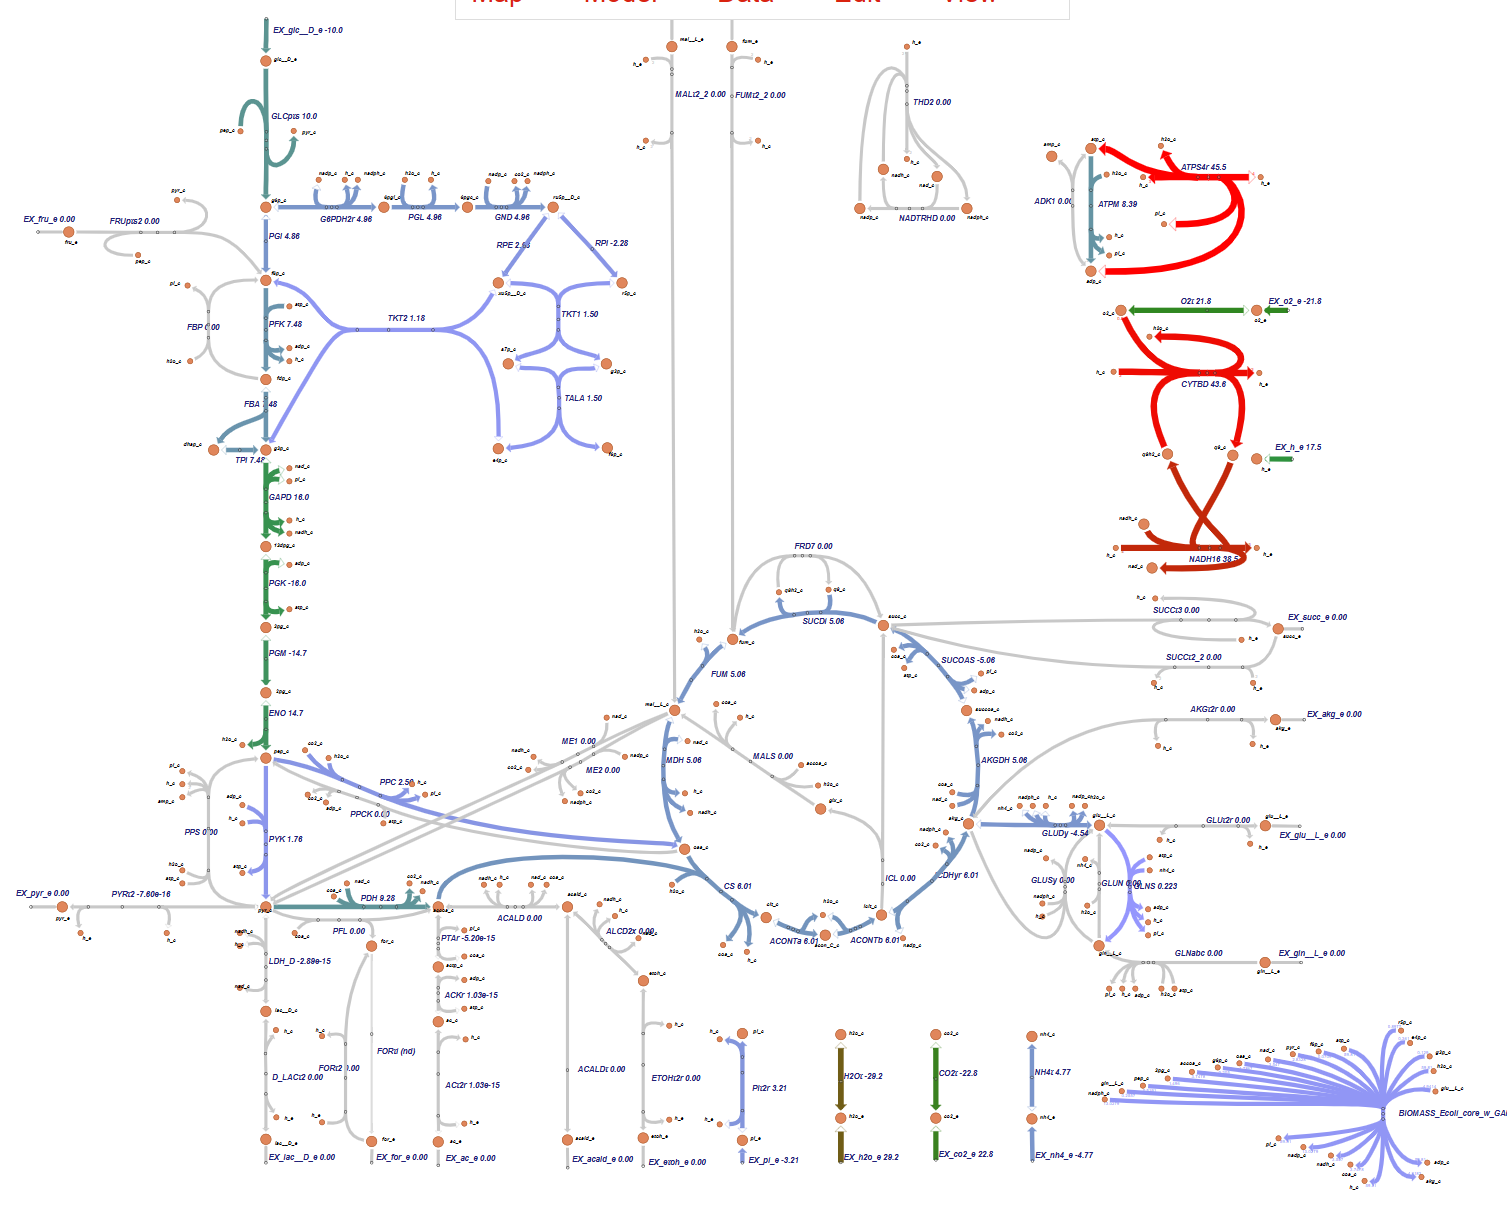

In [21]:
# Manual screen capture of the file olaila.html, and saved as a png file, just to visualize it here
Image("image/ecoli.png")

## Uploading treatment infos for all types of cancer at stage IV (Not finished)

In [ ]:
# Importing the raw data of survival, treatments and types
dfSurvival = pd.read_csv('C:\\Users\\Henrique\\Minha escrivaninha jupyter\\aplicacoes espeficificas\\cancer exploration\\data from ScBioPortal\\data_clinical_patient.txt', sep="\t", index_col=None, skiprows=4)
dfTreatments = pd.read_csv('C:\\Users\\Henrique\\Minha escrivaninha jupyter\\aplicacoes espeficificas\\cancer exploration\\data from ScBioPortal\\data_timeline_treatment.txt', sep="\t", index_col=None) 
dfTypes = pd.read_csv('C:\\Users\\Henrique\\Minha escrivaninha jupyter\\aplicacoes espeficificas\\cancer exploration\\data from ScBioPortal\\pog570_bcgsc_2020_clinical_data (1).tsv', sep="\t", index_col=None) 
dfTypes_relevant = dfTypes[['Patient ID','Cancer Type','Cancer Type Detailed']]
dfTypes_relevant = dfTypes_relevant.rename(columns={'Patient ID': 'PATIENT_ID'})

# Obtain a table with one patient per line, because on the treatment table each line is a treatment of a patient
# To do so, treatments will be grouped into the same string, separated by a "+" sign
dfTreatments_sorted = dfTreatments.sort_values(by=['PATIENT_ID', 'AGENT']) # Sorting the DataFrame by patient_id and treatment in alphabetical order
dfTreatments_unique = dfTreatments_sorted.drop_duplicates(subset=['PATIENT_ID', 'AGENT']) # Removing duplicates
dfTreatments_unique.dropna(subset=['AGENT'], inplace=True)
dfTreatmentsGrouped = dfTreatments_unique.groupby('PATIENT_ID')['AGENT'].agg('+'.join).reset_index()
dfTreatmentsGrouped

# Merging the 3 data frames
dfSurvivalAndTreatmentAll = pd.merge(dfSurvival,dfTreatmentsGrouped,  on='PATIENT_ID')
dfSurvivalAndTreatmentAll = pd.merge(dfSurvivalAndTreatmentAll, dfTypes_relevant,  on='PATIENT_ID')

# Adapting the status column from a string to a binary value
dfSurvivalAndTreatmentAll['OS_STATUS'] = dfSurvivalAndTreatmentAll['OS_STATUS'].replace({'1:DECEASED': 1, '0:LIVING': 0})

# 3 options:
selectedCancer = 'Hepatobiliary Cancer'
dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['Cancer Type'] == selectedCancer]

'''
selectedCancer = 'Stomach Adenocarcinoma'
dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['Cancer Type Detailed'] == selectedCancer]
'''

'''
selectedCancer = 'Lung Adenocarcinoma'
dfSurvivalAndTreatment = dfSurvivalAndTreatmentAll[dfSurvivalAndTreatmentAll['Cancer Type Detailed'] == selectedCancer]
'''

# finding the number of patients
patientsFound = len(dfSurvivalAndTreatment)

# Creating a Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Plotting survival curves for 3 most common treatments
plt.figure(figsize=(10, 6))

commonTreatments =  dfSurvivalAndTreatment['AGENT'].value_counts().head(3).index.tolist()
for treatment_type in commonTreatments:
    print()
    # Selecting data for the current treatment type
    treatment_data = dfSurvivalAndTreatment[dfSurvivalAndTreatment['AGENT'] == treatment_type]
    patientsFound = len(treatment_data)

    # Fiting the model
    kmf.fit(treatment_data['OS_MONTHS'], treatment_data['OS_STATUS'], label=treatment_type +' ('+str(patientsFound)+ ' patients)')

    # Ploting the survival curve
    kmf.plot_survival_function()


# Seting text sizes for different elements
plt.title('Courbes de survie Kaplan-Meier - '+ selectedCancer, fontsize=20, pad=10)
plt.xlabel('Mois depuis le diagnostic', fontsize=20)
plt.ylabel('Probabilité de survie', fontsize=20)

# Adjusting the tick label size for both x and y axes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(loc='lower right', fontsize=10)

plt.savefig('image/survival.png', transparent=True)
plt.show()